# Train a despeckling neural network

## Introduction
Confocal microscopes can operate in two modes which highlight different microscopic structures
in the tissue, reflectance and fluorescence.  
Reflectance signals are contaminated by multiplicative noise known
as speckle. Speckle is caused by the constructive
and destructive interference of the coherent returns
scattered by small reflectors within each resolution
cell.  
Assuming that the reflectance image is an average of L looks,
the observed SAR image $Y$ is related to the noise free image
$X$ by the following multiplicative model:  
$$ Y = F \odot X $$
$F$ is the speckle noise random
variable and $\odot$ denotes the element-wise multiplication.  
One
common assumption on $F$ is that it follows a Gamma distribution
with unit mean and variance $\frac{1}{L}$ giving the following probability density function:  
$$ p(F) = \frac{1}{\Gamma (L)} L^L F^{L-1} e^{-LF} $$

![Fluorescence](F.jpg)  
Fluorescende mode.
![Reflectance](R.jpg)  
Reflectance mode.

Our goal here is to reduce the speckle noise artifacts by means of a convolutional neural network.  
To train our model we need a noisy input and a clean target.
We will be using **artificially contaminated fluorescence** images to do so.

## Experiment

### Preparation

In [1]:
PATH = '/imatge/sgarcia/tfg'
DATA_ROOT = '/work/sgarcia/CM_crops'
BATCH_SIZE = 32
EPOCHS = 5

In [2]:
import os.path
import sys
sys.path.append(PATH)

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam
import numpy as np
from skimage.measure import compare_ssim as ssim
import tqdm
%matplotlib notebook
import matplotlib.pyplot as plt

from datasets import NoisyScansDataset
from despeckling import models

Defining the following variables will help us make our code device-agnostic

In [4]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda") if cuda else torch.device("cpu")

Let's define some helper functions

In [53]:
# this function returns a dictionary we can use to create our noisy dataset.
def get_noise_args(noise_type, L=1):
    if noise_type == 'gaussian':
        return {'random_variable': np.random.normal,
                'loc': 1, 'scale': 0.1}
    elif noise_type == 'gamma':
        return {'random_variable': np.random.gamma,
                'shape': L, 'scale': 1/L}
    elif noise_type == 'uniform':
        return {'random_variable': np.random.uniform,
                      'low': 1-0.3464, 'high': 1+0.3464}

In [6]:
# this function computes the sum of SSIM over a batch of images.
def compute_ssim(noisy_batch, clean_batch, median_filter=False):
    # iterate over batch to compute SSIM
    ssim_sum = 0
    for noisy, clean in zip(noisy_batch[:, 0], clean_batch[:, 0]):
        noisy = noisy.data.cpu().numpy()

        if median_filter:
            # scaling might not be necessary
            noisy = (noisy + 1) / 2 * 255
            noisy = noisy.astype(np.uint8)
            noisy = np.median(noisy)
            noisy = (noisy / 255.0 - 0.5) * 2

        ssim_sum += ssim(noisy, clean.data.cpu().numpy(), data_range=2)
    return ssim_sum / noisy_batch.shape[0]

In [7]:
# this function returns a torch model based on an easy name
def get_model(model_str, num_layers):
    if model_str == 'log_add':
        return models.LogAddDespeckle(num_layers)
    elif model_str == 'log_subtract':
        return models.LogSubtractDespeckle(num_layers)
    elif model_str == 'multiply':
        return models.MultiplyDespeckle(num_layers)
    elif model_str == 'divide':
        return models.DivideDespeckle(num_layers)
    else:
        raise NotImplementedError(model_str + 'model does not exist.')

In [8]:
# this function returns a pytorch loss object based on a easy name
def get_criterion(criterion_str):
    if criterion_str == 'mse':
        return MSELoss()
    elif criterion_str == 'l1':
        return L1Loss()

In [70]:
# We define the training loop in a function so we can reuse it with different hyperparameters.
def train(epochs):
    # live loss plots
    fig = plt.figure()
    loss_plt = fig.add_subplot(211)
    loss_plt.set_title('Losses')
    loss_plt.set_xlabel('training iteration')
    ssims_plt = fig.add_subplot(212)
    ssims_plt.set_title('Validation SSIM')
    ssims_plt.set_xlabel('training iteration')
    fig.tight_layout()
    plt.ion()

    fig.show()
    fig.canvas.draw()

    train_loss = []
    val_idx = []
    val_loss = []
    ssim_input = []
    ssim_output = []

    for epoch in range(epochs):
        # TRAINING.
        model.train()

        print('Epoch {} of {}'.format(epoch, epochs - 1))
        input_and_target = tqdm.tqdm_notebook(train_dataloader, total=len(train_dataloader))

        for x_batch, target_batch in input_and_target:
            x_batch, target_batch = x_batch.float().to(device), target_batch.float().to(device)

            optimizer.zero_grad()
            output_batch = model(x_batch)

            loss = criterion(output_batch, target_batch)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.data.cpu().numpy())

            input_and_target.set_description('Train loss = {0:.3f}'.format(loss))

        # VALIDATION.
        print('Validation:')
        model.eval()
        input_and_target = tqdm.tqdm(val_dataloader, total=len(val_dataloader))

        val_idx.append((epoch + 1) * len(train_dataloader))
        med_loss_eval = 0
        prev_loss_eval = 0
        val_loss_sum = 0
        ssim_input_sum = 0
        ssim_output_sum = 0
        with torch.no_grad():
            for x_batch, target_batch in input_and_target:
                x_batch, target_batch = x_batch.float().to(device), target_batch.float().to(device)
                output_batch = model(x_batch)
                loss = criterion(output_batch, target_batch)
                med_loss_eval += loss.data.cpu().numpy()
                prev_loss_eval = criterion(x_batch, target_batch).data.cpu().numpy()

                val_loss_sum += loss
                ssim_in = compute_ssim(x_batch, target_batch)
                ssim_out = compute_ssim(output_batch, target_batch)
                ssim_input_sum += ssim_in
                ssim_output_sum += ssim_out

                input_and_target.set_description(
                    'Output loss = {0:.3f}'.format(loss)
                    + ' Input loss = {0:.3f}'.format(prev_loss_eval)
                    + ' Input SSIM = {0:.3f}'.format(ssim_in)
                    + ' Output SSIM = {0:.3f}'.format(ssim_out))

        # plotting
        val_loss.append(val_loss_sum / len(val_dataloader))
        ssim_input.append(ssim_input_sum / len(val_dataloader))
        ssim_output.append(ssim_output_sum / len(val_dataloader))
        loss_plt.plot(train_loss, 'k--', label='training')
        loss_plt.plot(val_idx, val_loss, 'b', label='validation')
        ssims_plt.plot(val_idx, ssim_input, 'r--', label='input SSIM')
        ssims_plt.plot(val_idx, ssim_output, 'g', label='output SSIM')
        if epoch == 0:
            ssims_plt.legend()
            loss_plt.legend()
        fig.canvas.draw()


### Define the dataset

The dataset returns a pair of images: a multiplicative-noise contaminated image and its corresponding clean image.

We do a 90/10 train/validation split and contaminate the images with a gamma-distributed noise assuming $L=1$

In [10]:
# dataset returns (noisy, clean) tuple
dataset = NoisyScansDataset(DATA_ROOT, 'F', get_noise_args('gamma'), apply_random_crop=True)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

Here is an example of a clean and noisy pair

<IPython.core.display.Javascript object>


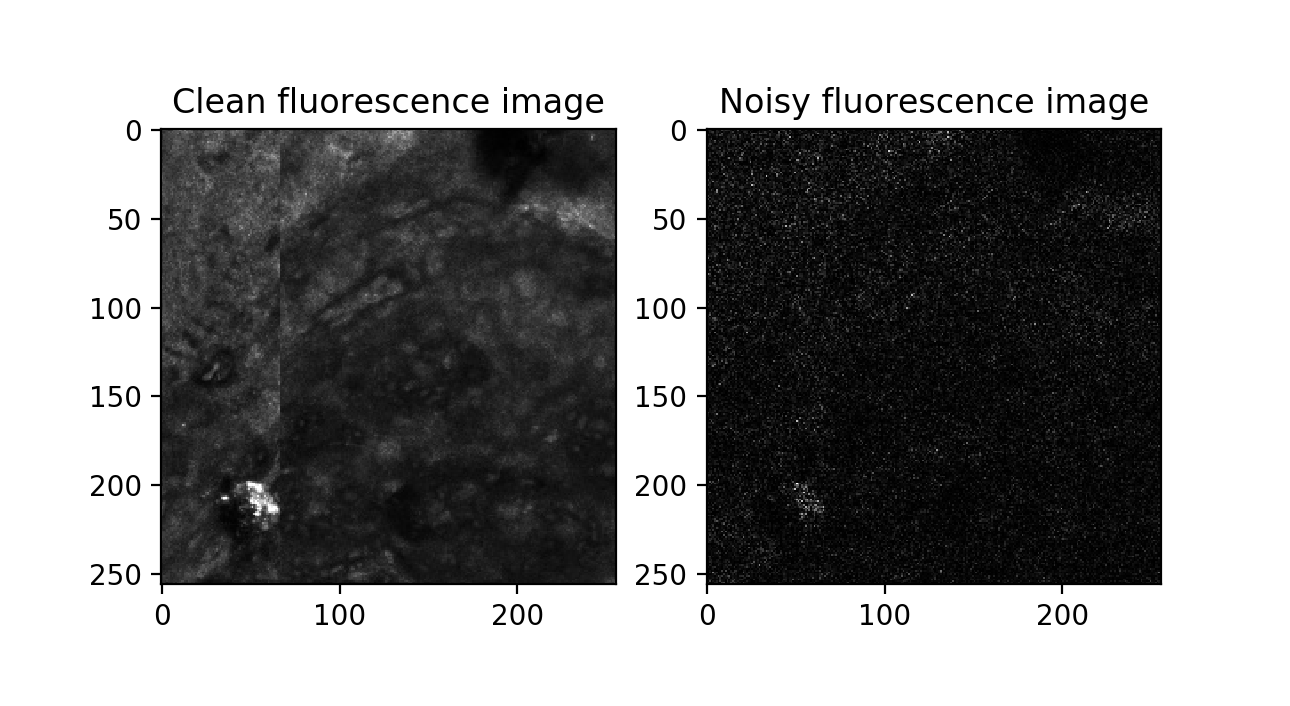

Text(0.5, 1.0, 'Noisy fluorescence image')

In [11]:
noisy_sample, clean_sample = train_dataset[0]

fig = plt.figure()
clean_plt = fig.add_subplot(121)
noisy_plt = fig.add_subplot(122)
clean_plt.imshow(np.transpose(clean_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
clean_plt.set_title('Clean fluorescence image')
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Noisy fluorescence image')

The noisy image looks TOO NOISY. The noise distribution mode is 0, so we are zero-ing lots of pixel values.

### Define loss function

Our loss functions will consist on a distance between the output of the model and the clean image.  
L1 (manhattan) or MSE (euclidian) are basic distance measures.

Let's try with MSE. MSE penalizes less the errors between (-1,1) and more the rest.

<IPython.core.display.Javascript object>


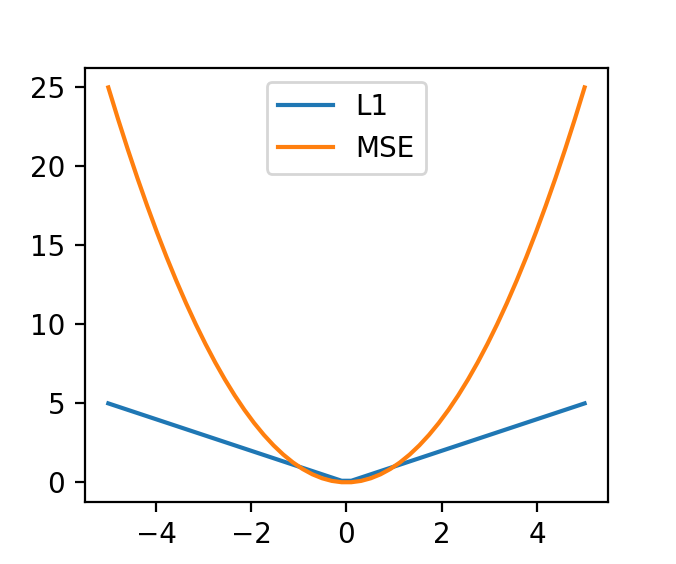

In [12]:
x = np.linspace(-5,5)
l1 = np.abs(x)
l2 = x ** 2

fig = plt.figure()
distances_plt = fig.add_subplot(111)
distances_plt.plot(x, l1, label='L1')
distances_plt.plot(x, l2, label='MSE')
distances_plt.legend()
distances_plt.set_xlabel('arror')
fig.show()

In [13]:
criterion = get_criterion('mse')

### Define despeckling network

Our model consists on a series of convolutional layers followed by a skip connection connected to the input.

* We can transform our input image to the logarithm space (so the noise becomes and additive one) and use a additive skip connection to remove the log noise, then "come back" to linear space.
* Or use a multiplicative or division connection and work directly with the original space.

Every convolutional layer is followed by a batch normalization step and a parametric linear rectified unit (PReLU) activation function. The skip connection is followed by a sigmoid activation to make sure the output is between 0 and 1.  
![Architecture](architecture.png)

Let's try with a divide connection with just 2 convolutional layers

In [14]:
model = get_model('divide', 3)

In [15]:
if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

### Define Adam optimizer.

In [16]:
optimizer = Adam(params=model.parameters(), lr=1e-3)

### Training 

<IPython.core.display.Javascript object>


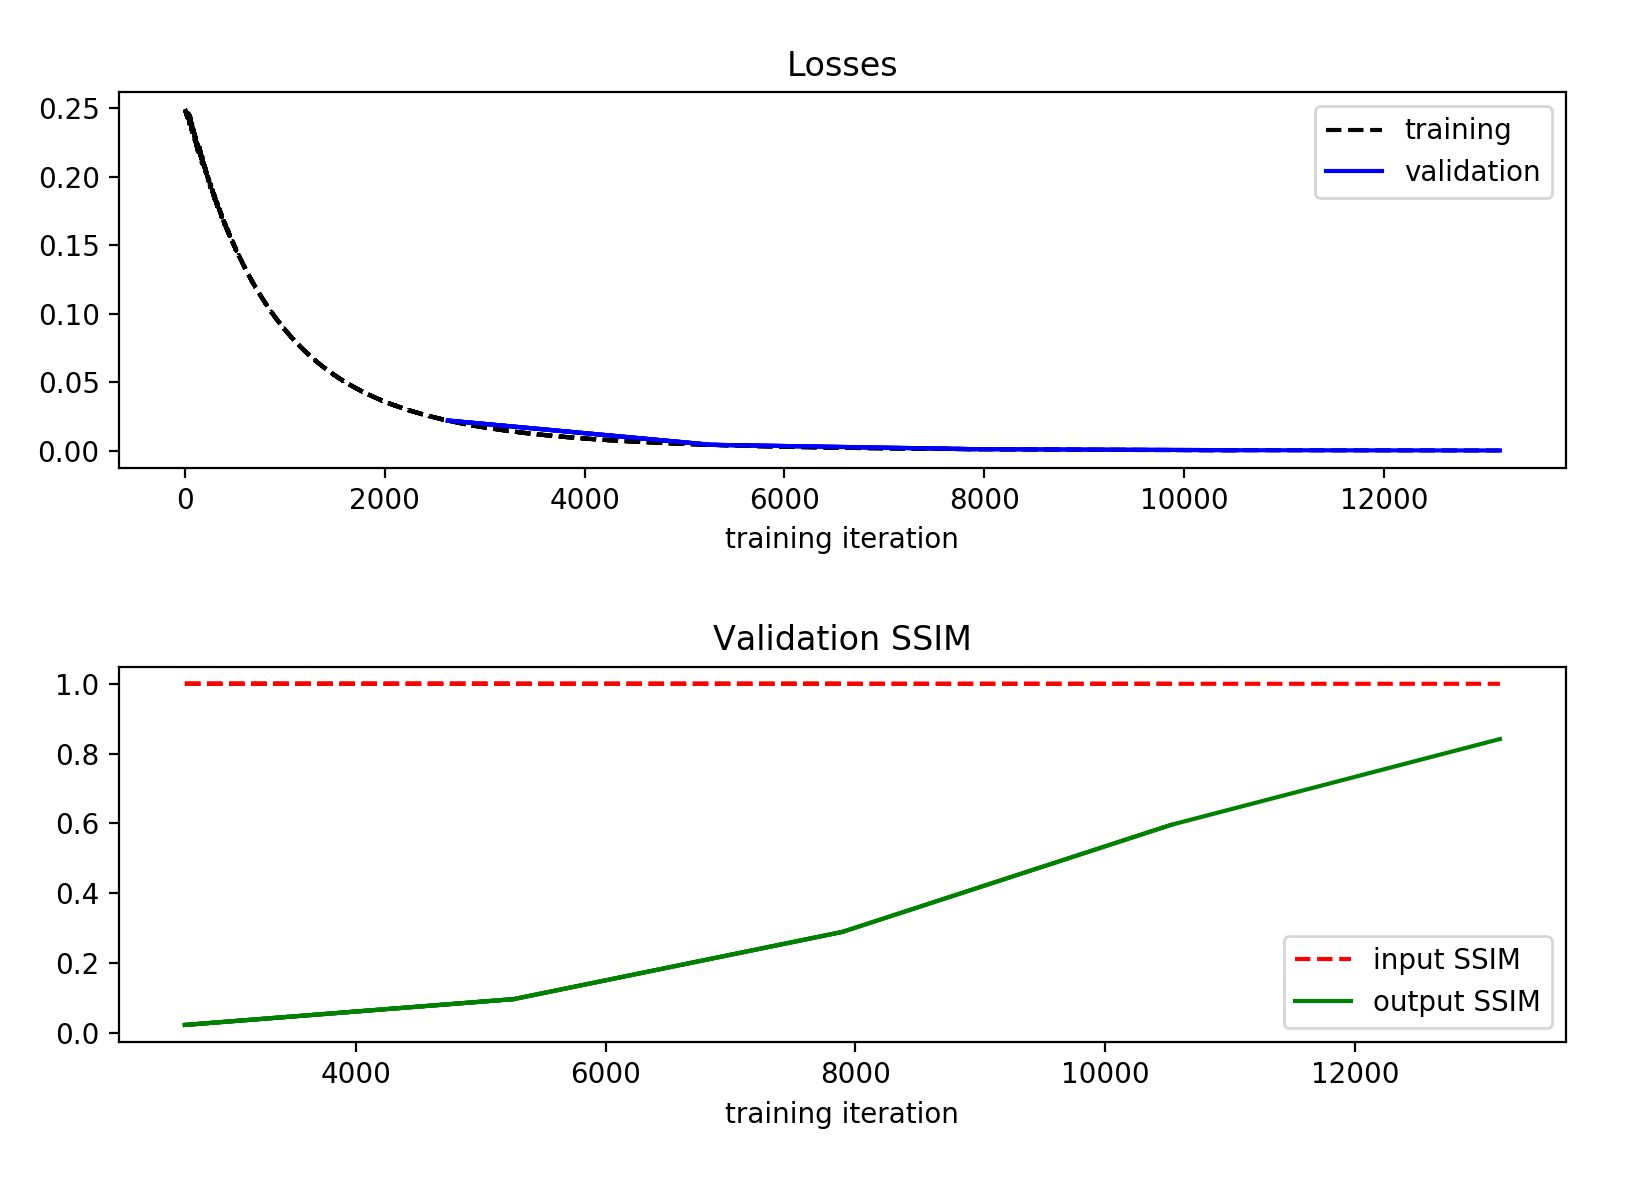

  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 0 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.022 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.024: 100%|██████████| 293/293 [06:25<00:00,  1.92it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 1 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.004 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.097: 100%|██████████| 293/293 [06:26<00:00,  1.95it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 2 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.001 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.291: 100%|██████████| 293/293 [06:25<00:00,  1.88it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 3 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.598: 100%|██████████| 293/293 [06:27<00:00,  1.92it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 4 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.843: 100%|██████████| 293/293 [06:29<00:00,  1.91it/s]


In [17]:
train(EPOCHS)

<IPython.core.display.Javascript object>


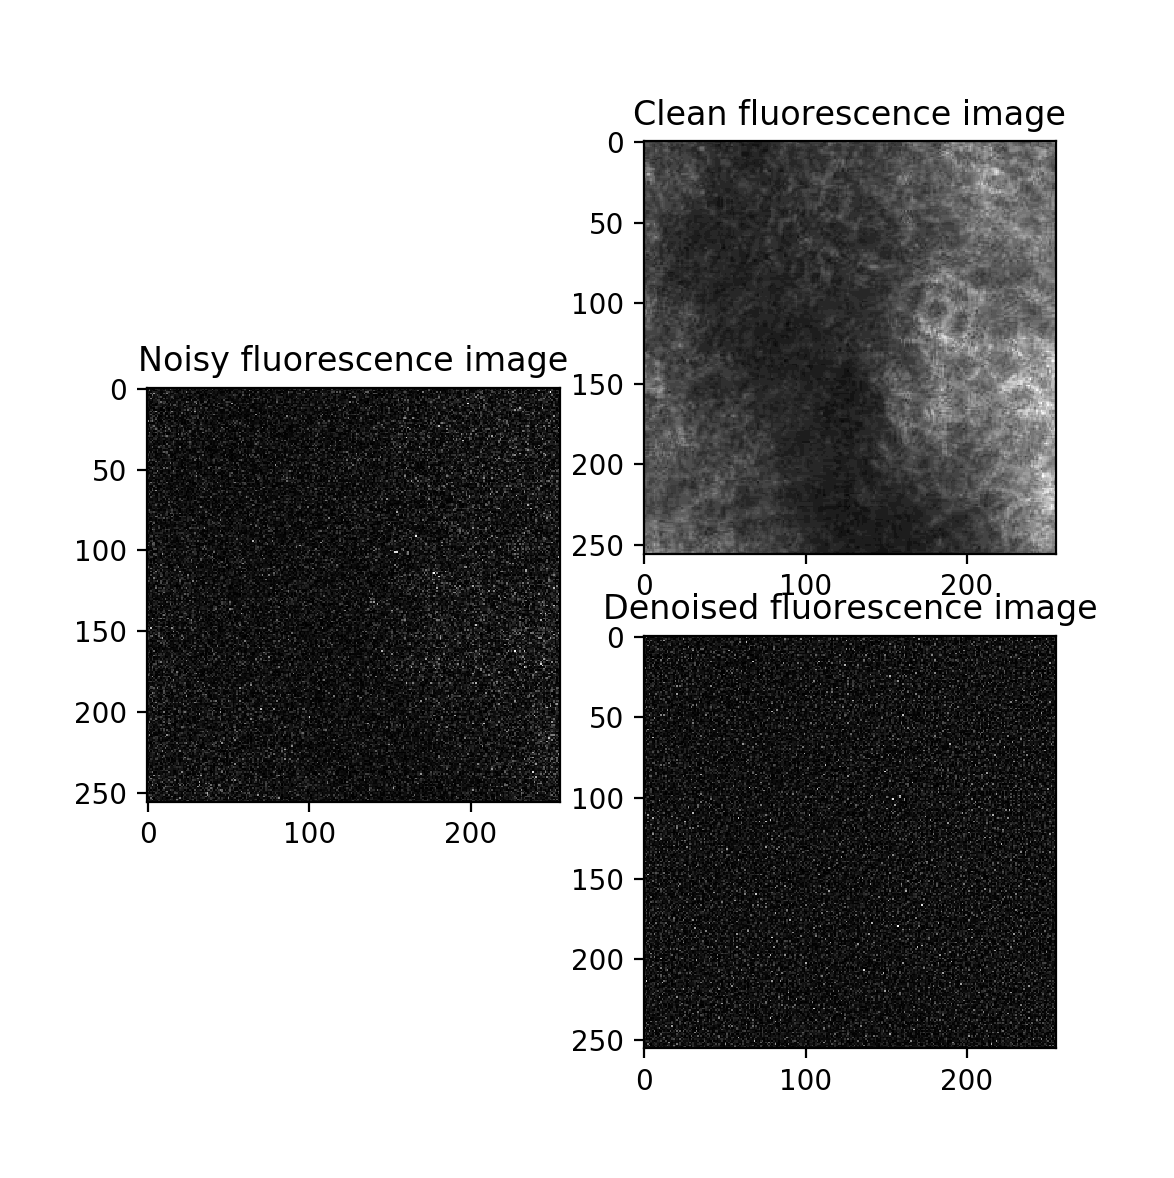

Text(0.5, 1.0, 'Denoised fluorescence image')

In [40]:
noisy_sample, clean_sample = val_dataset[18]
denoised_sample = model(noisy_sample.unsqueeze(0).float().to(device))

fig = plt.figure()
noisy_plt = fig.add_subplot(121)
clean_plt = fig.add_subplot(222)
denoised_plt = fig.add_subplot(224)
clean_plt.imshow(np.transpose(clean_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
clean_plt.set_title('Clean fluorescence image')
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Noisy fluorescence image')
denoised_plt.imshow(np.transpose(denoised_sample.cpu().detach().numpy()[0], (1,2,0))[:,:,0], cmap='gray')
denoised_plt.set_title('Denoised fluorescence image')

The denoised images don't look denoised at all.  
Let's try with the multiplicative aproach, so the convolutional blocks are predicting the multiplicative inverse of the noise ($\frac{1}{F}$).

In [42]:
criterion = get_criterion('l1')

model = get_model('multiply', 3)

optimizer = Adam(params=model.parameters(), lr=1e-3)

if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

<IPython.core.display.Javascript object>


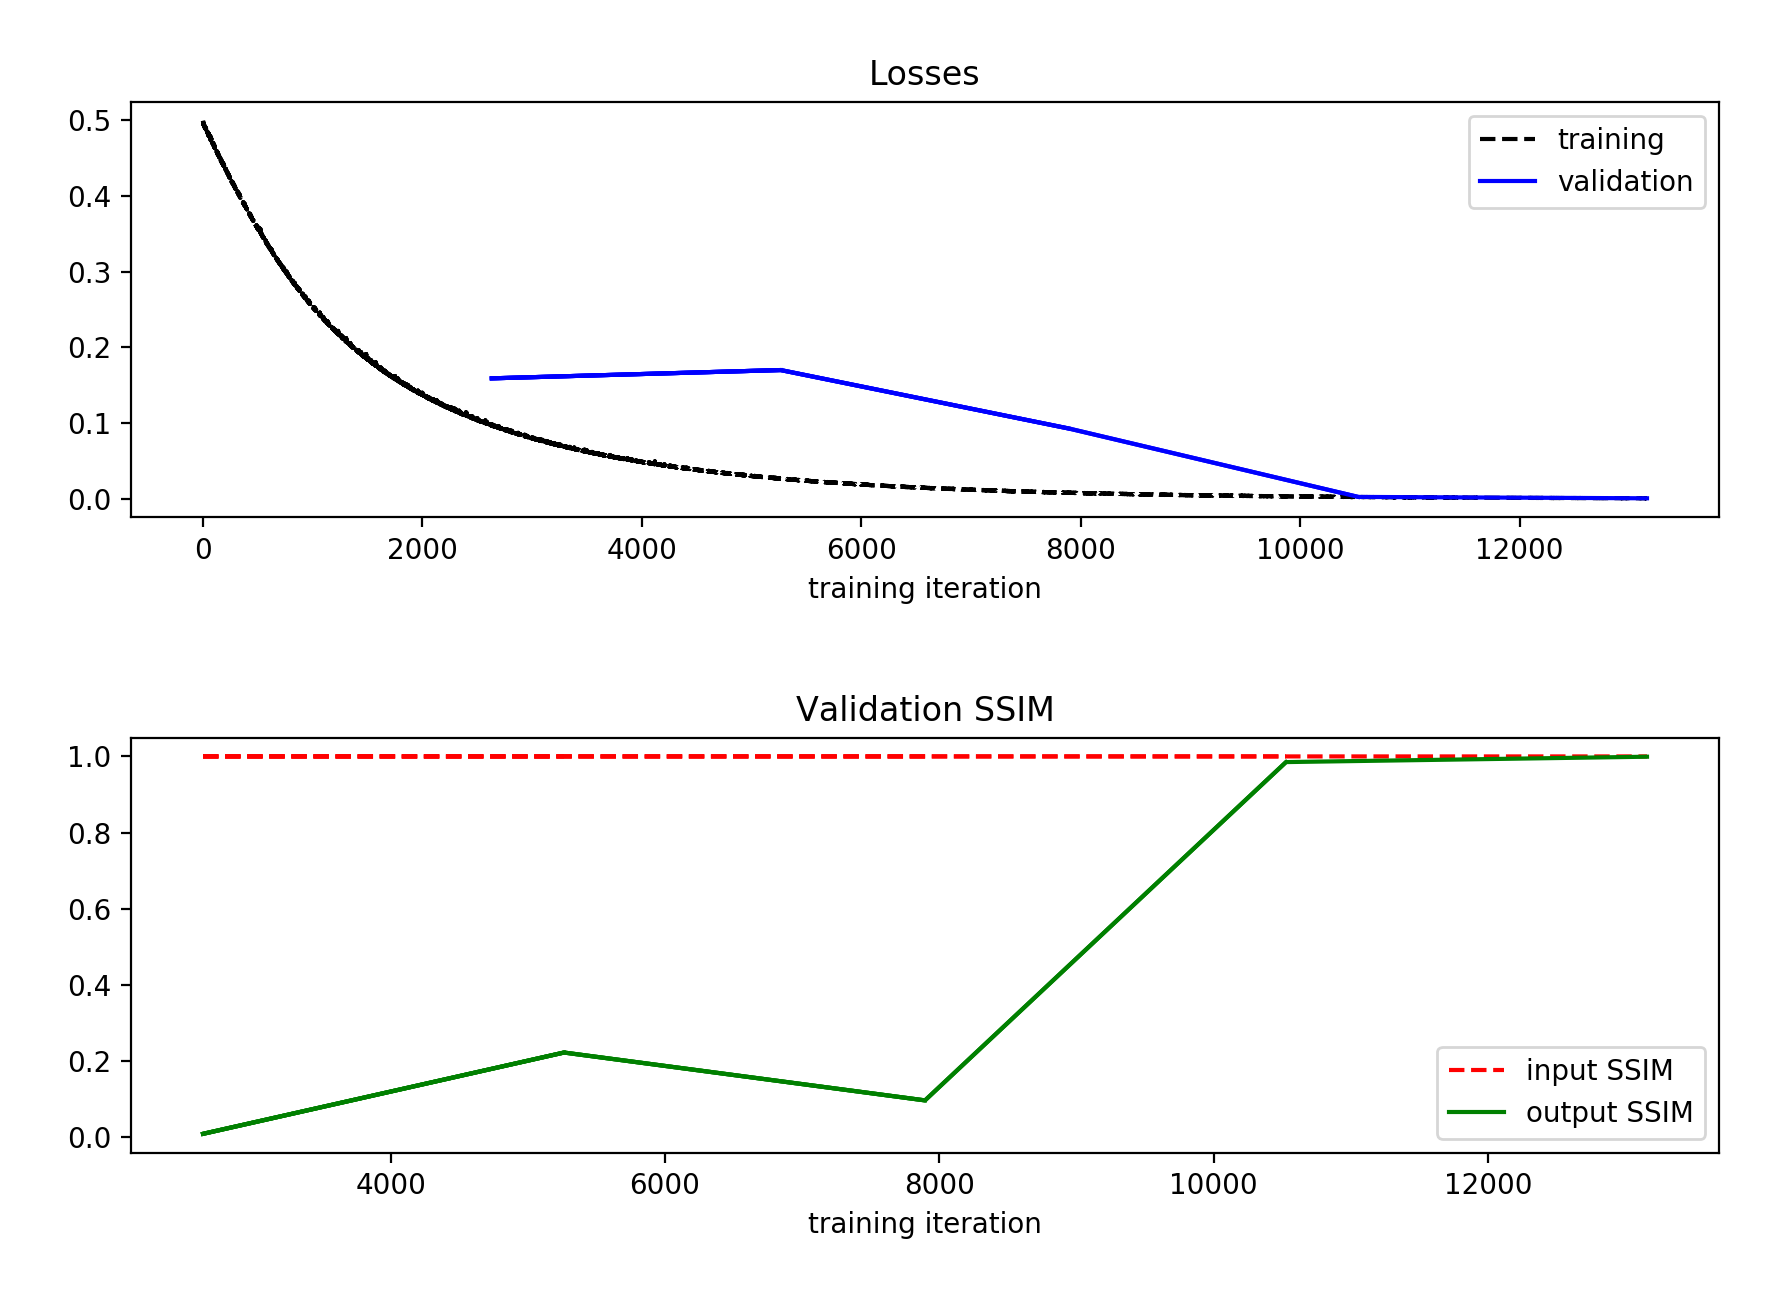

  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 0 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.145 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.012: 100%|██████████| 293/293 [06:17<00:00,  1.98it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 1 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.253 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.203: 100%|██████████| 293/293 [06:18<00:00,  1.97it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 2 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.094 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.138: 100%|██████████| 293/293 [08:23<00:00,  1.64it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 3 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.002 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.986: 100%|██████████| 293/293 [08:28<00:00,  1.67it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 4 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.001 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 0.999: 100%|██████████| 293/293 [08:44<00:00,  1.57it/s]


In [43]:
train(EPOCHS)

<IPython.core.display.Javascript object>


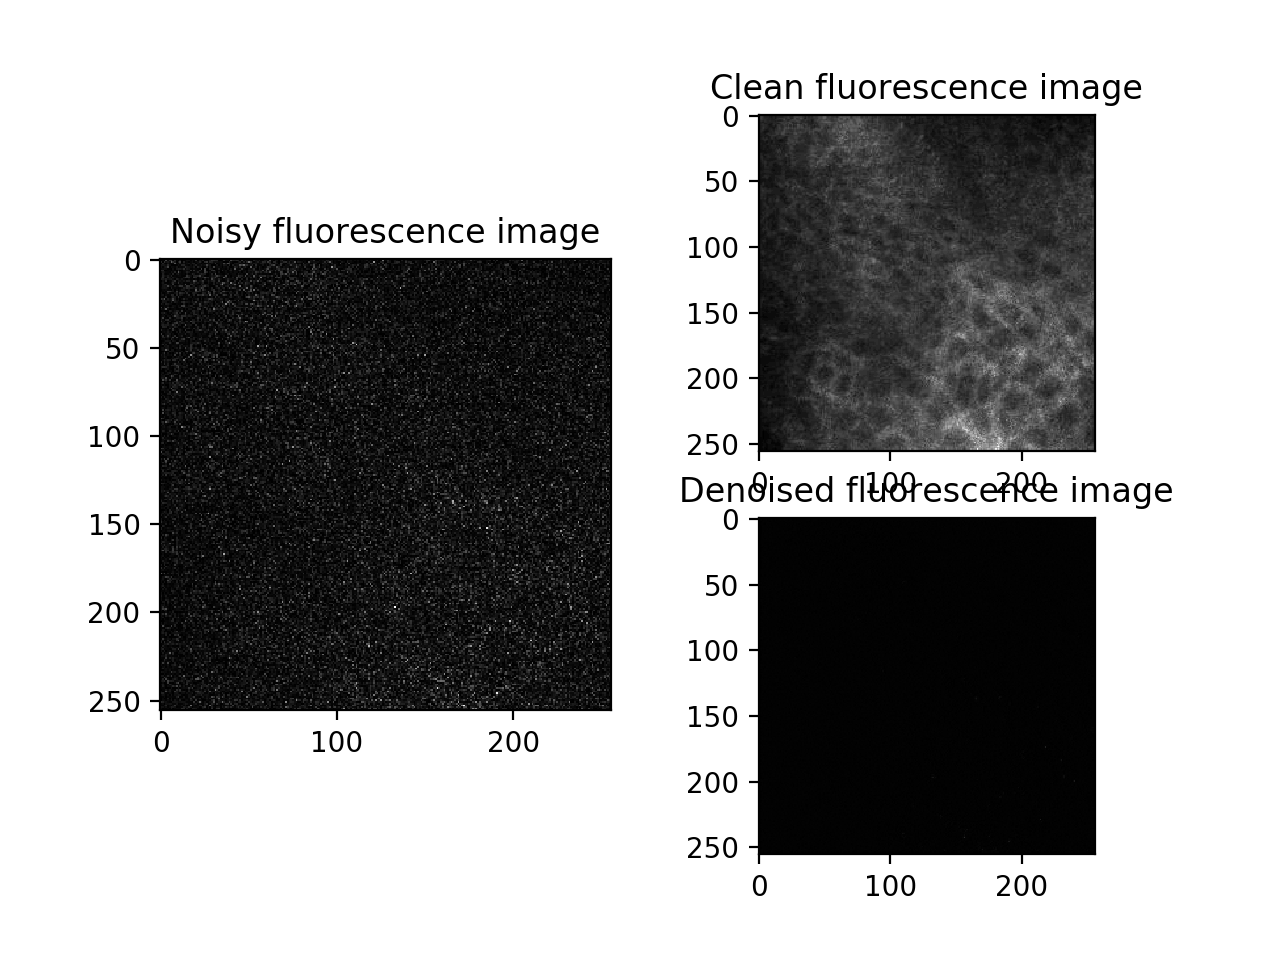

Text(0.5, 1.0, 'Denoised fluorescence image')

In [44]:
noisy_sample, clean_sample = val_dataset[18]
denoised_sample = model(noisy_sample.unsqueeze(0).float().to(device))

fig = plt.figure()
noisy_plt = fig.add_subplot(121)
clean_plt = fig.add_subplot(222)
denoised_plt = fig.add_subplot(224)
clean_plt.imshow(np.transpose(clean_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
clean_plt.set_title('Clean fluorescence image')
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Noisy fluorescence image')
denoised_plt.imshow(np.transpose(denoised_sample.cpu().detach().numpy()[0], (1,2,0))[:,:,0], cmap='gray')
denoised_plt.set_title('Denoised fluorescence image')

Now we will train a model that will try to remove the noise in the logarithmic space.

In [45]:
criterion = get_criterion('mse')

model = get_model('log_add', 3)

optimizer = Adam(params=model.parameters(), lr=1e-3)

if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

<IPython.core.display.Javascript object>


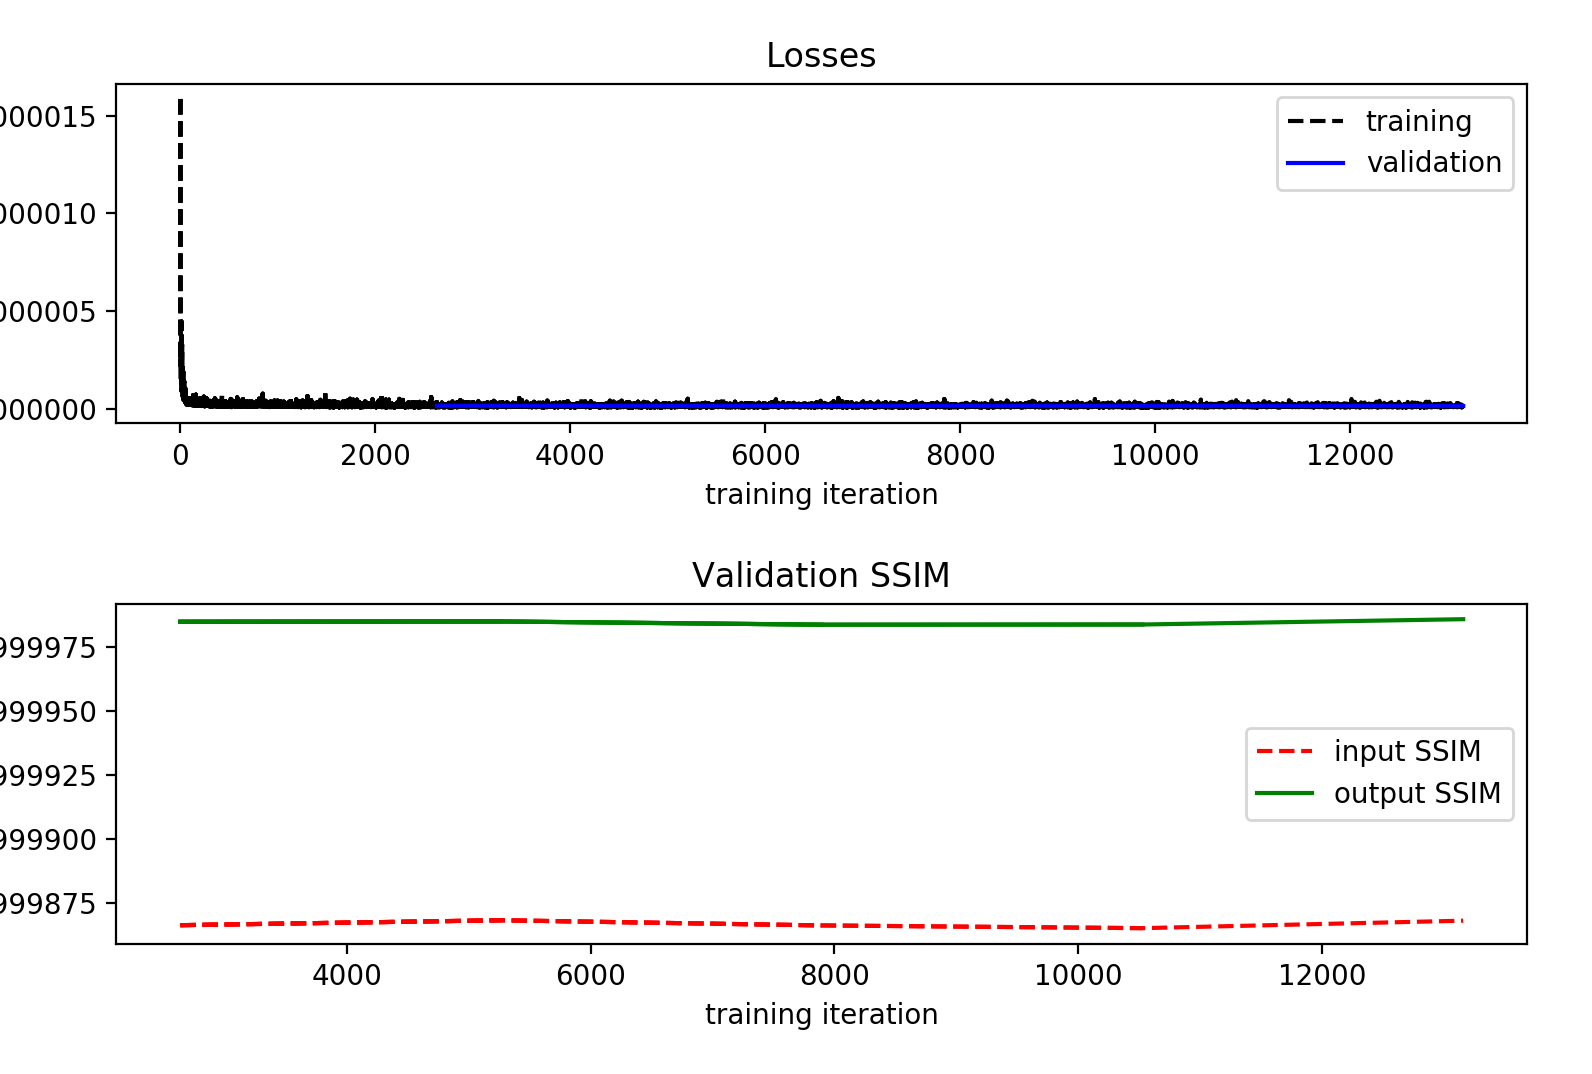

  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 0 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [06:18<00:00,  1.97it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 1 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [08:27<00:00,  1.66it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 2 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [08:28<00:00,  1.69it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 3 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [08:27<00:00,  1.66it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 4 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [08:27<00:00,  1.66it/s]


In [46]:
train(EPOCHS)

<IPython.core.display.Javascript object>


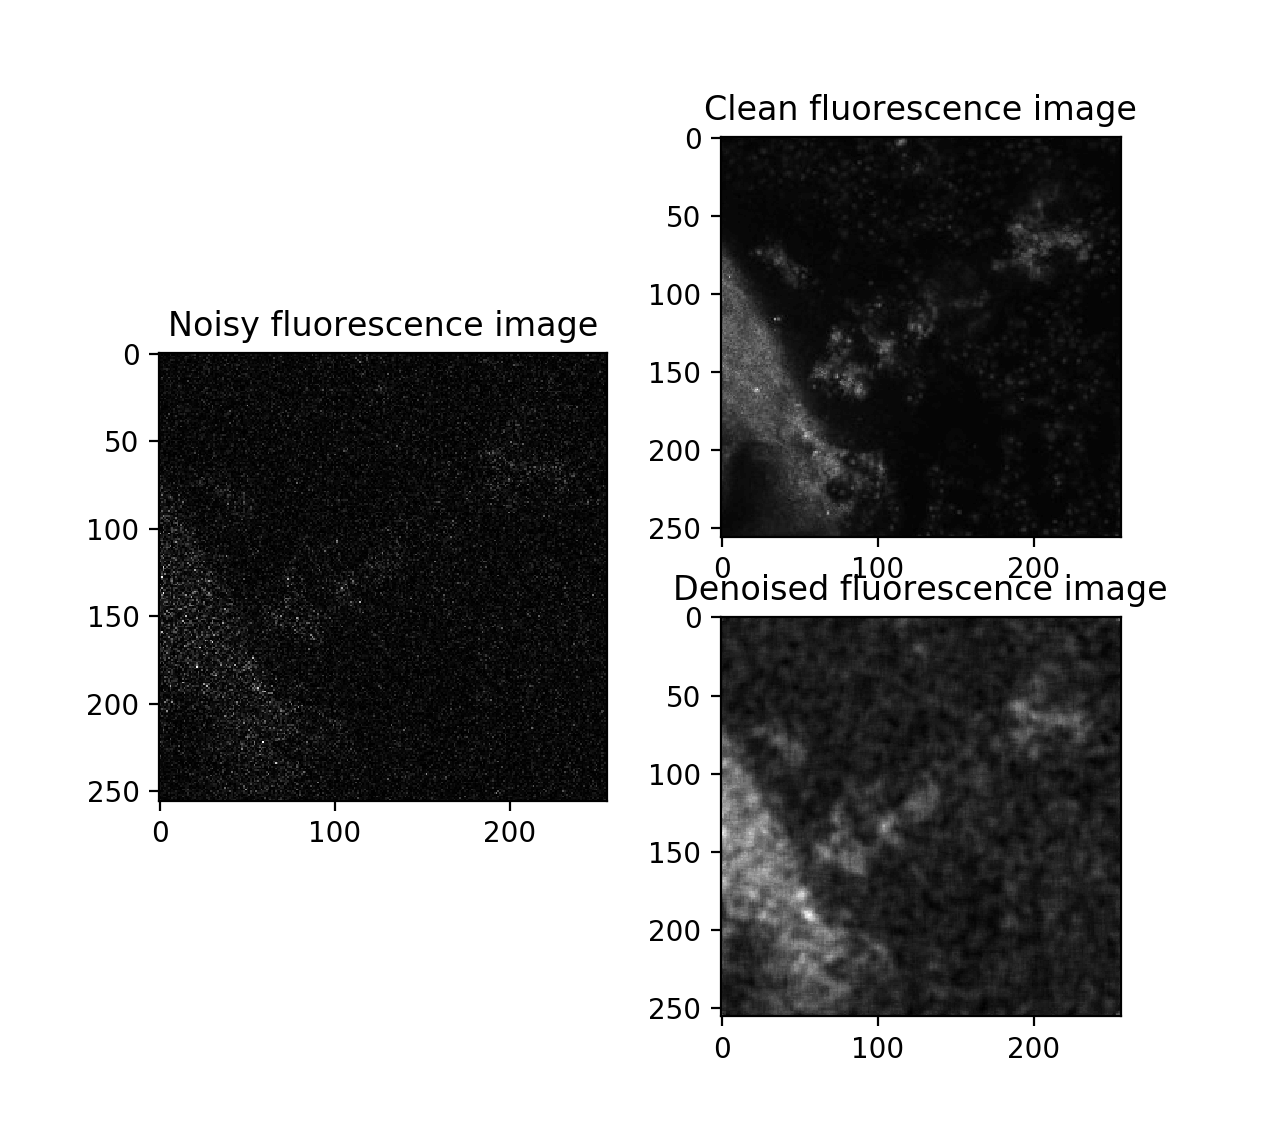

Text(0.5, 1.0, 'Denoised fluorescence image')

In [47]:
noisy_sample, clean_sample = val_dataset[2]
denoised_sample = model(noisy_sample.unsqueeze(0).float().to(device))

fig = plt.figure()
noisy_plt = fig.add_subplot(121)
clean_plt = fig.add_subplot(222)
denoised_plt = fig.add_subplot(224)
clean_plt.imshow(np.transpose(clean_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
clean_plt.set_title('Clean fluorescence image')
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Noisy fluorescence image')
denoised_plt.imshow(np.transpose(denoised_sample.detach().cpu().numpy()[0], (1,2,0))[:,:,0], cmap='gray')
denoised_plt.set_title('Denoised fluorescence image')

### New noise model

The model doesn't do a bad job at reconstructing the image, but the noisy image is not "realistic" compared to the reflectance images

In [48]:
import imageio
r_sample = imageio.imread(os.path.join(DATA_ROOT, '0_4608-10240_R.tif'))

fig = plt.figure()
r_plt = fig.add_subplot(121)
r_plt.imshow(r_sample, cmap='gray')
r_plt.set_title('Reflectance image')
noisy_plt = fig.add_subplot(122)
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Contaminated fluorescence image')

/imatge/sgarcia/pytorch-venv/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:4275: UserWarning: 54784 is not a valid PREDICTOR
  warnings.warn(str(e))


ValueError: cannot decompress JPEG

##### Let's now assume our reflectance images come from an average of 10 looks ($L=10$)

In [49]:
# dataset returns (noisy, clean) tuple
dataset = NoisyScansDataset(DATA_ROOT, 'F', get_noise_args('gamma', L=10), apply_random_crop=True)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [50]:
criterion = get_criterion('mse')

model = get_model('log_add', 3)

optimizer = Adam(params=model.parameters(), lr=1e-3)

if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

<IPython.core.display.Javascript object>


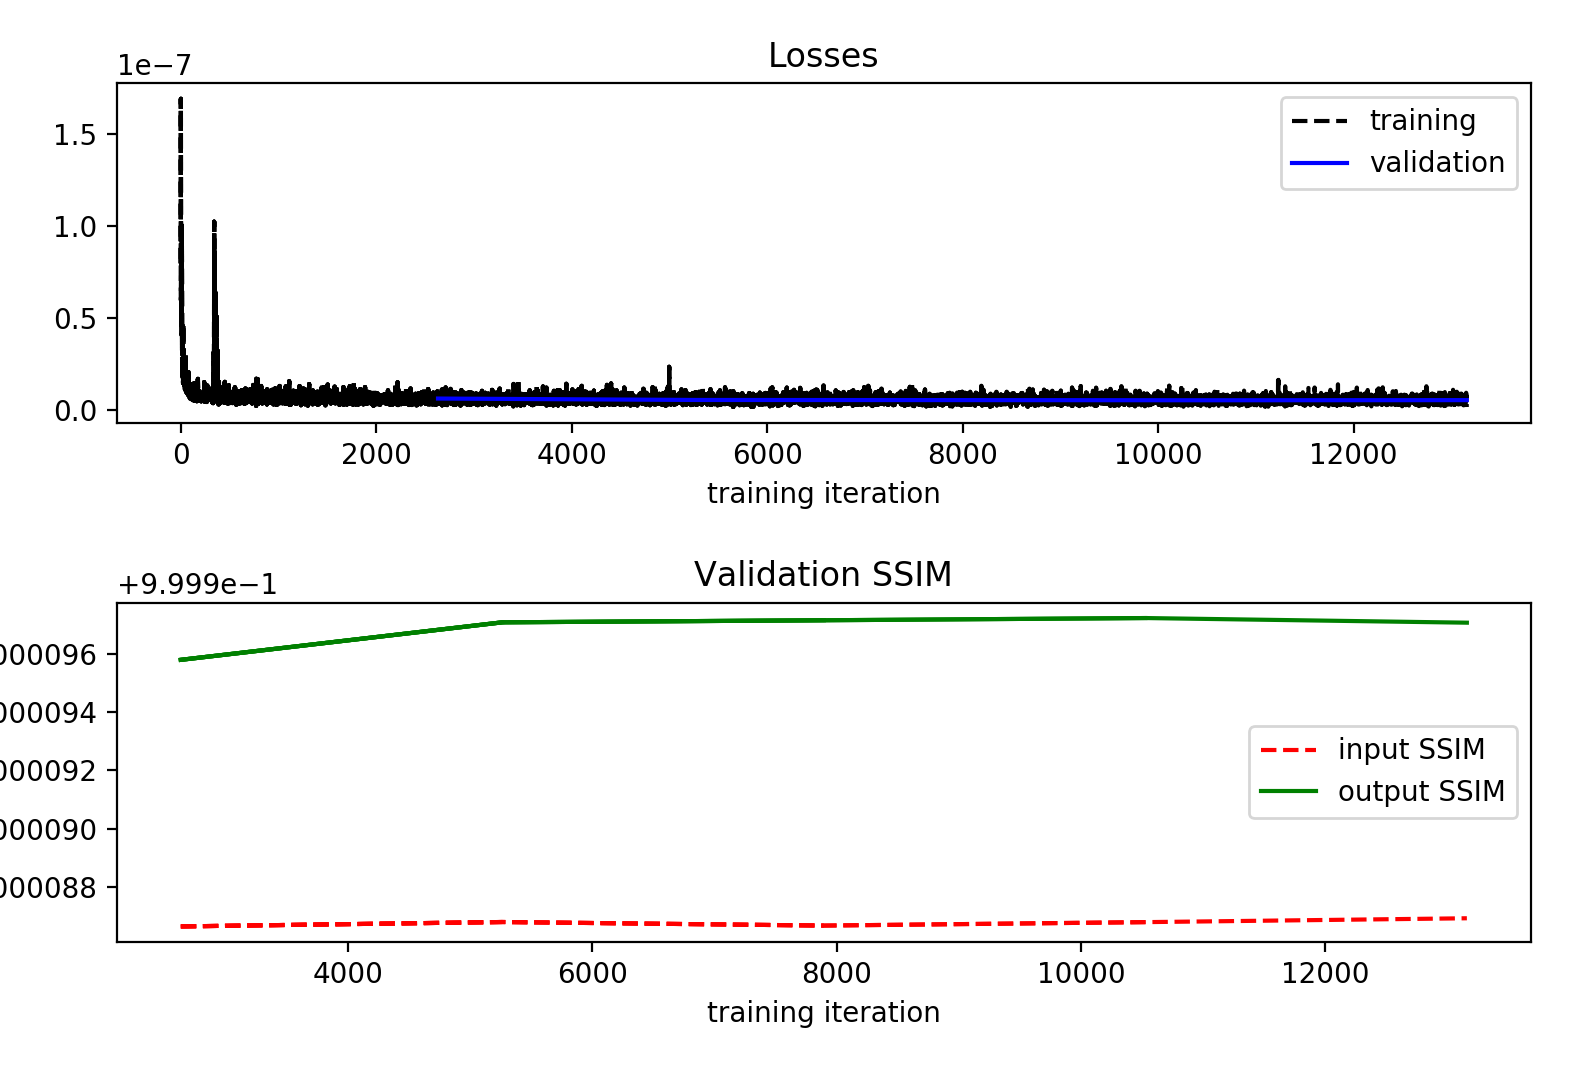

  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 0 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [10:30<00:00,  1.37it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 1 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [11:31<00:00,  1.30it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 2 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [08:44<00:00,  1.63it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 3 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [07:54<00:00,  1.61it/s]
  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 4 of 4


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:


Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000: 100%|██████████| 293/293 [07:58<00:00,  1.59it/s]


In [51]:
train(EPOCHS)

<IPython.core.display.Javascript object>


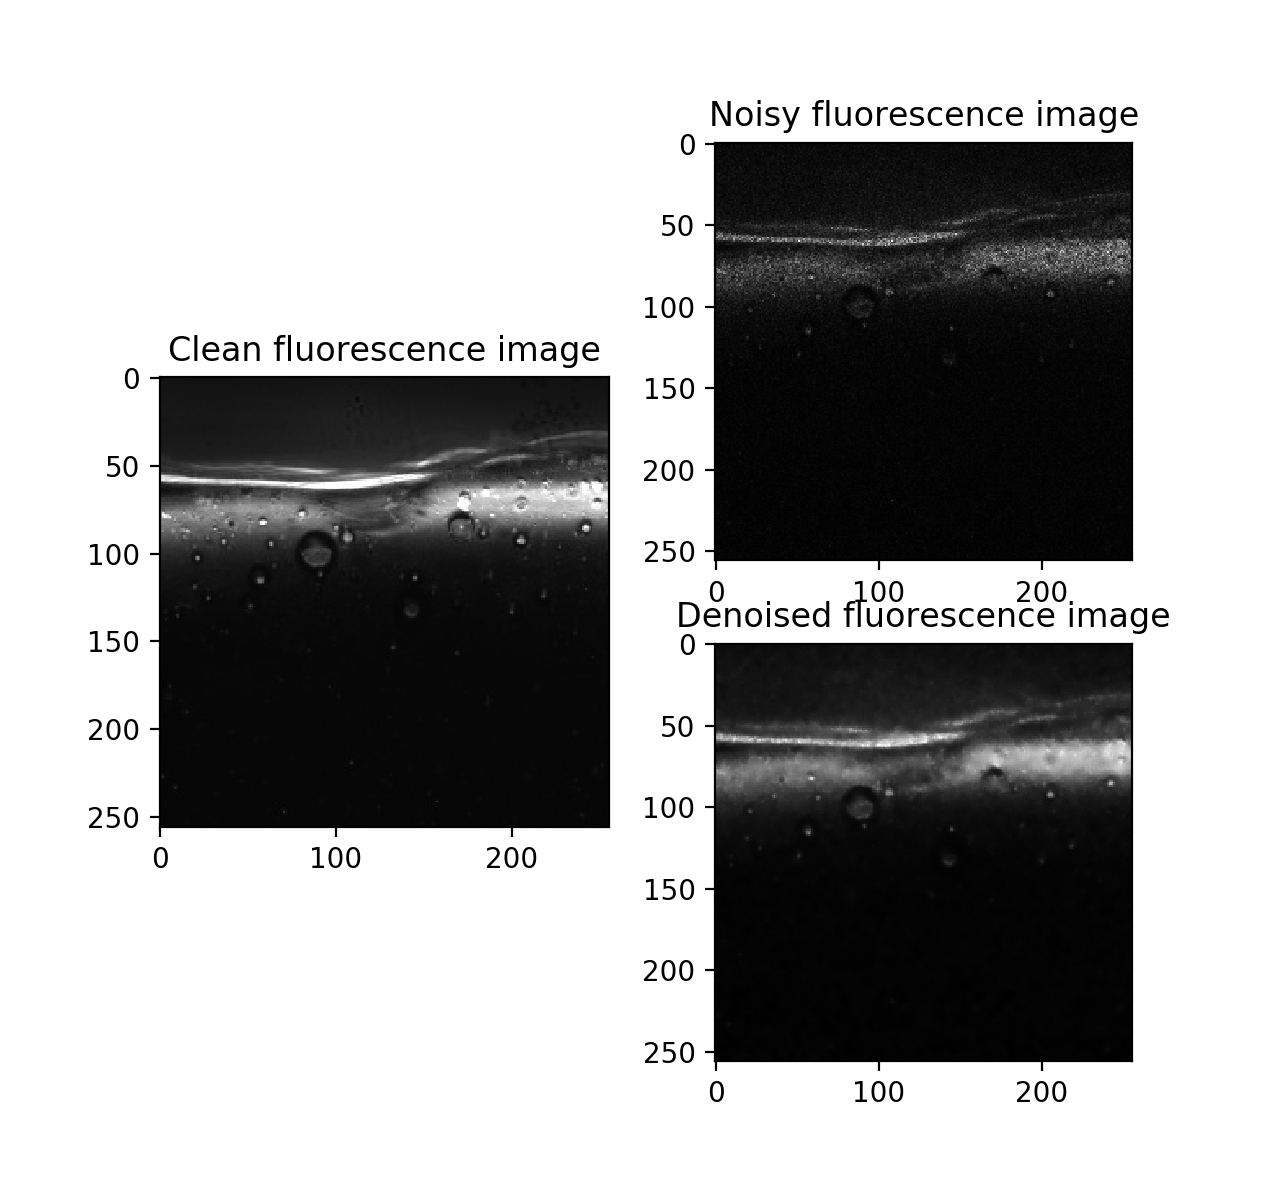

Text(0.5, 1.0, 'Denoised fluorescence image')

In [52]:
noisy_sample, clean_sample = val_dataset[2]
denoised_sample = model(noisy_sample.unsqueeze(0).float().to(device))

fig = plt.figure()
clean_plt = fig.add_subplot(121)
noisy_plt = fig.add_subplot(222)
denoised_plt = fig.add_subplot(224)
clean_plt.imshow(np.transpose(clean_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
clean_plt.set_title('Clean fluorescence image')
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Noisy fluorescence image')
denoised_plt.imshow(np.transpose(denoised_sample.cpu().detach().numpy()[0], (1,2,0))[:,:,0], cmap='gray')
denoised_plt.set_title('Denoised fluorescence image')

##### Uniform multiplicative noise.

In [54]:
# dataset returns (noisy, clean) tuple
dataset = NoisyScansDataset(DATA_ROOT, 'F', get_noise_args('uniform'), apply_random_crop=True)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [67]:
criterion = get_criterion('mse')

model = get_model('log_add', 3)

optimizer = Adam(params=model.parameters(), lr=1e-3)

if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

<IPython.core.display.Javascript object>


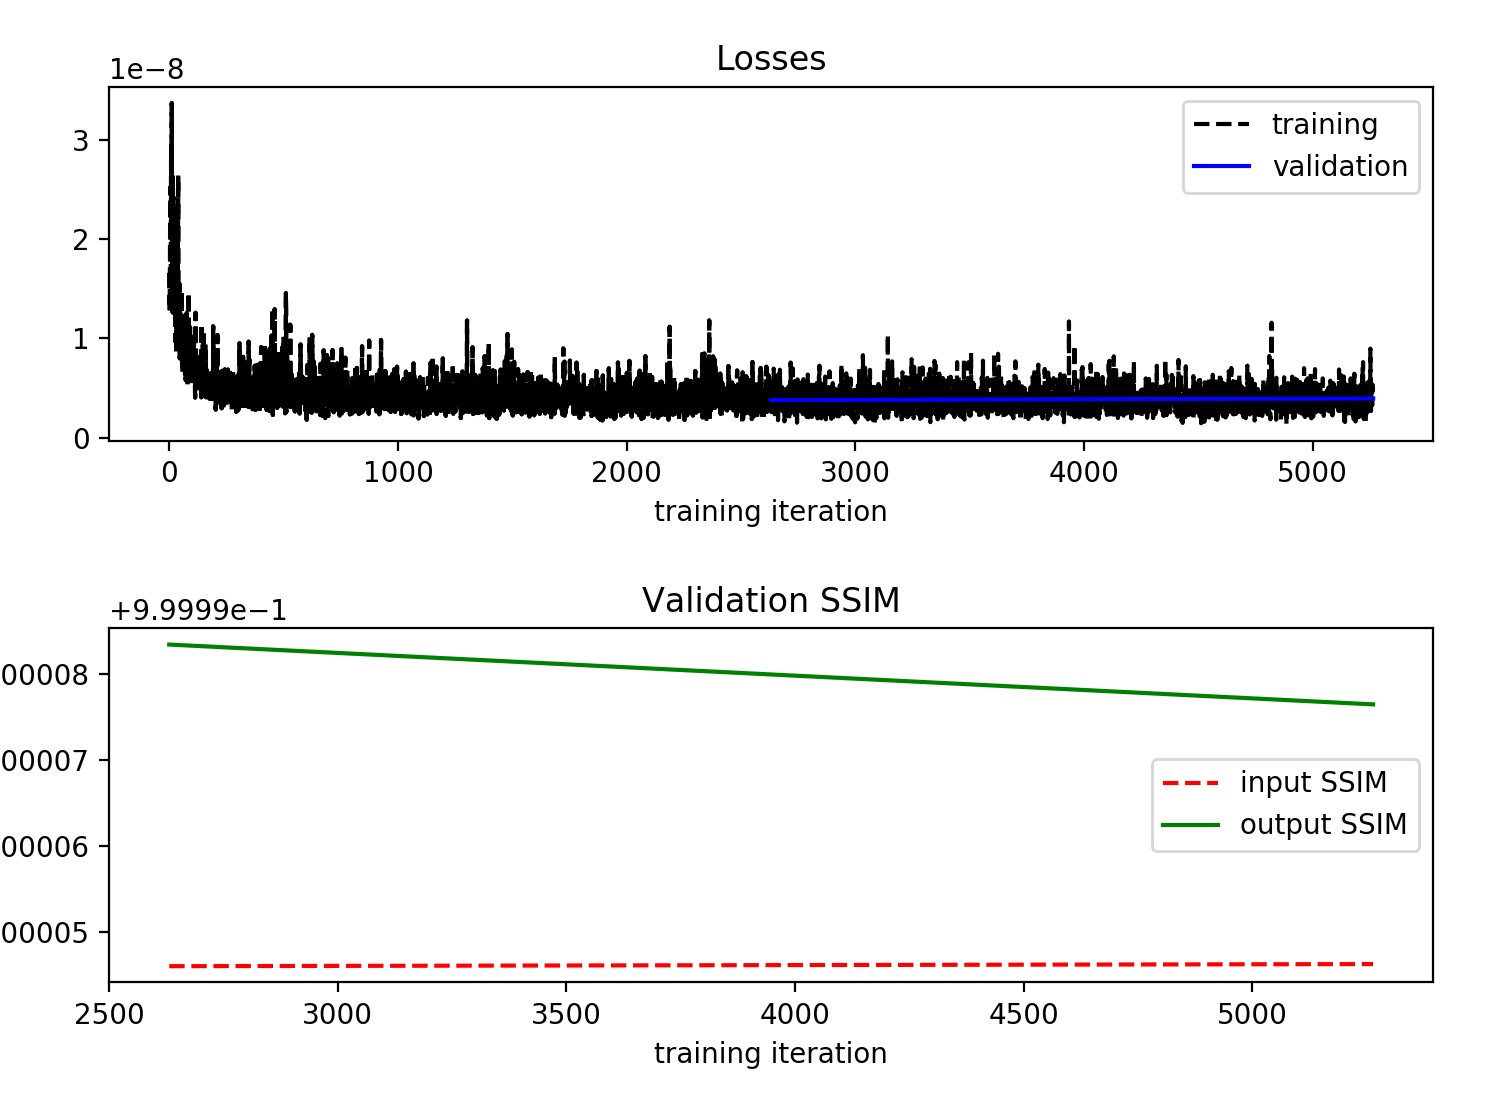


  0%|          | 0/2632 [00:00<?, ?it/s]

Epoch 0 of 1



Train loss = 0.000:   4%|▍         | 111/2632 [01:02<23:12,  1.81it/s]


Train loss = 0.000:   8%|▊         | 221/2632 [02:03<22:14,  1.81it/s]


Train loss = 0.000:  13%|█▎        | 331/2632 [03:04<20:37,  1.86it/s]


Train loss = 0.000:  17%|█▋        | 441/2632 [04:04<19:56,  1.83it/s]


Train loss = 0.000:  21%|██        | 551/2632 [05:04<19:32,  1.78it/s]


Train loss = 0.000:  25%|██▌       | 661/2632 [06:05<17:54,  1.83it/s]


Train loss = 0.000:  29%|██▉       | 771/2632 [07:05<16:28,  1.88it/s]


Train loss = 0.000:  33%|███▎      | 881/2632 [08:06<16:42,  1.75it/s]


Train loss = 0.000:  38%|███▊      | 991/2632 [09:06<15:03,  1.82it/s]


Train loss = 0.000:  42%|████▏     | 1100/2632 [10:06<13:38,  1.87it/s]


Train loss = 0.000:  46%|████▌     | 1209/2632 [11:06<13:20,  1.78it/s]


Train loss = 0.000:  50%|█████     | 1318/2632 [12:06<12:19,  1.78it/s]


Train loss = 0.000:  54%|█████▍    | 1427/2632 [13:06<10:58,  1.83it/s]


Train loss = 0.000:  58%|█████▊    | 1536/2632 [14:06<09:24,  1.94it/s]


Train loss = 0.000:  62%|██████▎   | 1645/2632 [15:06<09:21,  1.76it/s]


Train loss = 0.000:  67%|██████▋   | 1754/2632 [16:06<08:04,  1.81it/s]


Train loss = 0.000:  71%|███████   | 1863/2632 [17:05<07:05,  1.81it/s]


Train loss = 0.000:  75%|███████▍  | 1972/2632 [18:06<05:45,  1.91it/s]


Train loss = 0.000:  79%|███████▉  | 2081/2632 [19:05<04:57,  1.85it/s]


Train loss = 0.000:  83%|████████▎ | 2190/2632 [20:05<03:58,  1.85it/s]


Train loss = 0.000:  87%|████████▋ | 2299/2632 [21:05<03:04,  1.81it/s]


Train loss = 0.000:  91%|█████████▏| 2408/2632 [22:05<02:02,  1.83it/s]


Train loss = 0.000:  96%|█████████▌| 2517/2632 [23:05<01:01,  1.88it/s]


Train loss = 0.000: 100%|█████████▉| 2626/2632 [24:05<00:03,  1.81it/s]


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:



Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   0%|          | 0/293 [00:04<?, ?it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   0%|          | 1/293 [00:04<21:04,  4.33s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   0%|          | 1/293 [00:05<21:04,  4.33s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 2/293 [00:05<16:30,  3.40s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 2/293 [00:06<16:30,  3.40s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 3/293 [00:06<12:47,  2.65s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 3/293 [00:07<12:47,  2.65s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|▏         | 4/293 [00:07<10:23,  2

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  21%|██        | 62/293 [01:05<03:55,  1.02s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 63/293 [01:05<03:50,  1.00s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 63/293 [01:06<03:50,  1.00s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 64/293 [01:06<03:49,  1.00s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 64/293 [01:07<03:49,  1.00s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 65/293 [01:07<03:46,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 65/293 [01:08<03:46,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  23%|██▎       | 66/293 [

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  42%|████▏     | 124/293 [02:06<02:46,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 125/293 [02:06<02:44,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 125/293 [02:07<02:44,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 126/293 [02:07<02:44,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 126/293 [02:08<02:44,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 127/293 [02:08<02:43,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 127/293 [02:09<02:43,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  44%|████▎     | 1

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  63%|██████▎   | 186/293 [03:07<01:47,  1.01s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 187/293 [03:07<01:46,  1.01s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 187/293 [03:08<01:46,  1.01s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 188/293 [03:08<01:43,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 188/293 [03:09<01:43,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  65%|██████▍   | 189/293 [03:09<01:45,  1.01s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  65%|██████▍   | 189/293 [03:10<01:45,  1.01s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  65%|██████▍   | 1

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▍ | 248/293 [04:09<00:44,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▍ | 249/293 [04:09<00:43,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▍ | 249/293 [04:10<00:43,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▌ | 250/293 [04:10<00:42,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▌ | 250/293 [04:11<00:42,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  86%|████████▌ | 251/293 [04:11<00:41,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  86%|████████▌ | 251/293 [04:11<00:41,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  86%|████████▌ | 2

Epoch 1 of 1



Train loss = 0.000:   4%|▍         | 111/2632 [01:03<24:06,  1.74it/s]


Train loss = 0.000:   8%|▊         | 221/2632 [02:03<23:11,  1.73it/s]


Train loss = 0.000:  13%|█▎        | 331/2632 [03:04<20:45,  1.85it/s]


Train loss = 0.000:  17%|█▋        | 441/2632 [04:04<20:30,  1.78it/s]


Train loss = 0.000:  21%|██        | 551/2632 [05:05<19:16,  1.80it/s]


Train loss = 0.000:  25%|██▌       | 661/2632 [06:05<18:59,  1.73it/s]


Train loss = 0.000:  29%|██▉       | 771/2632 [07:06<16:58,  1.83it/s]


Train loss = 0.000:  33%|███▎      | 881/2632 [08:06<16:36,  1.76it/s]


Train loss = 0.000:  38%|███▊      | 991/2632 [09:06<14:43,  1.86it/s]


Train loss = 0.000:  42%|████▏     | 1100/2632 [10:06<13:44,  1.86it/s]


Train loss = 0.000:  46%|████▌     | 1209/2632 [11:06<12:59,  1.82it/s]


Train loss = 0.000:  50%|█████     | 1318/2632 [12:06<12:21,  1.77it/s]


Train loss = 0.000:  54%|█████▍    | 1427/2632 [13:06<10:44,  1.87it/s]


Train loss = 0.000:  58%|█████▊    | 1536/2632 [14:05<09:37,  1.90it/s]


Train loss = 0.000:  62%|██████▎   | 1645/2632 [15:06<09:56,  1.66it/s]


Train loss = 0.000:  67%|██████▋   | 1754/2632 [16:05<08:10,  1.79it/s]


Train loss = 0.000:  71%|███████   | 1863/2632 [17:05<07:10,  1.79it/s]


Train loss = 0.000:  75%|███████▍  | 1972/2632 [18:05<05:51,  1.88it/s]


Train loss = 0.000:  79%|███████▉  | 2081/2632 [19:06<05:18,  1.73it/s]


Train loss = 0.000:  83%|████████▎ | 2190/2632 [20:05<04:09,  1.77it/s]


Train loss = 0.000:  87%|████████▋ | 2299/2632 [21:05<03:00,  1.84it/s]


Train loss = 0.000:  91%|█████████▏| 2408/2632 [22:05<01:56,  1.92it/s]


Train loss = 0.000:  96%|█████████▌| 2517/2632 [23:05<01:07,  1.70it/s]


Train loss = 0.000: 100%|█████████▉| 2626/2632 [24:05<00:03,  1.83it/s]


  0%|          | 0/293 [00:00<?, ?it/s]

Validation:



Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   0%|          | 0/293 [00:04<?, ?it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   0%|          | 1/293 [00:04<21:29,  4.42s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   0%|          | 1/293 [00:05<21:29,  4.42s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 2/293 [00:05<16:47,  3.46s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 2/293 [00:06<16:47,  3.46s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 3/293 [00:06<13:21,  2.76s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|          | 3/293 [00:07<13:21,  2.76s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:   1%|▏         | 4/293 [00:07<10:43,  2

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  21%|██        | 62/293 [01:05<03:46,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 63/293 [01:05<03:45,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 63/293 [01:06<03:45,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 64/293 [01:06<03:43,  1.03it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 64/293 [01:07<03:43,  1.03it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 65/293 [01:07<03:42,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  22%|██▏       | 65/293 [01:08<03:42,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  23%|██▎       | 66/293 [

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  42%|████▏     | 124/293 [02:07<02:47,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 125/293 [02:07<02:59,  1.07s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 125/293 [02:08<02:59,  1.07s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 126/293 [02:08<02:54,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 126/293 [02:09<02:54,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 127/293 [02:09<02:52,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  43%|████▎     | 127/293 [02:09<02:52,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  44%|████▎     | 1

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  63%|██████▎   | 186/293 [03:08<01:44,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 187/293 [03:08<01:44,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 187/293 [03:09<01:44,  1.01it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 188/293 [03:09<01:43,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  64%|██████▍   | 188/293 [03:10<01:43,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  65%|██████▍   | 189/293 [03:10<01:42,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  65%|██████▍   | 189/293 [03:11<01:42,  1.02it/s]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  65%|██████▍   | 1

Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▍ | 248/293 [04:09<00:46,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▍ | 249/293 [04:09<00:45,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▍ | 249/293 [04:10<00:45,  1.04s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▌ | 250/293 [04:10<00:44,  1.03s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  85%|████████▌ | 250/293 [04:11<00:44,  1.03s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  86%|████████▌ | 251/293 [04:11<00:42,  1.00s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  86%|████████▌ | 251/293 [04:12<00:42,  1.00s/it]
Output loss = 0.000 Input loss = 0.000 Input SSIM = 1.000 Output SSIM = 1.000:  86%|████████▌ | 2

In [71]:
train(2)

<IPython.core.display.Javascript object>


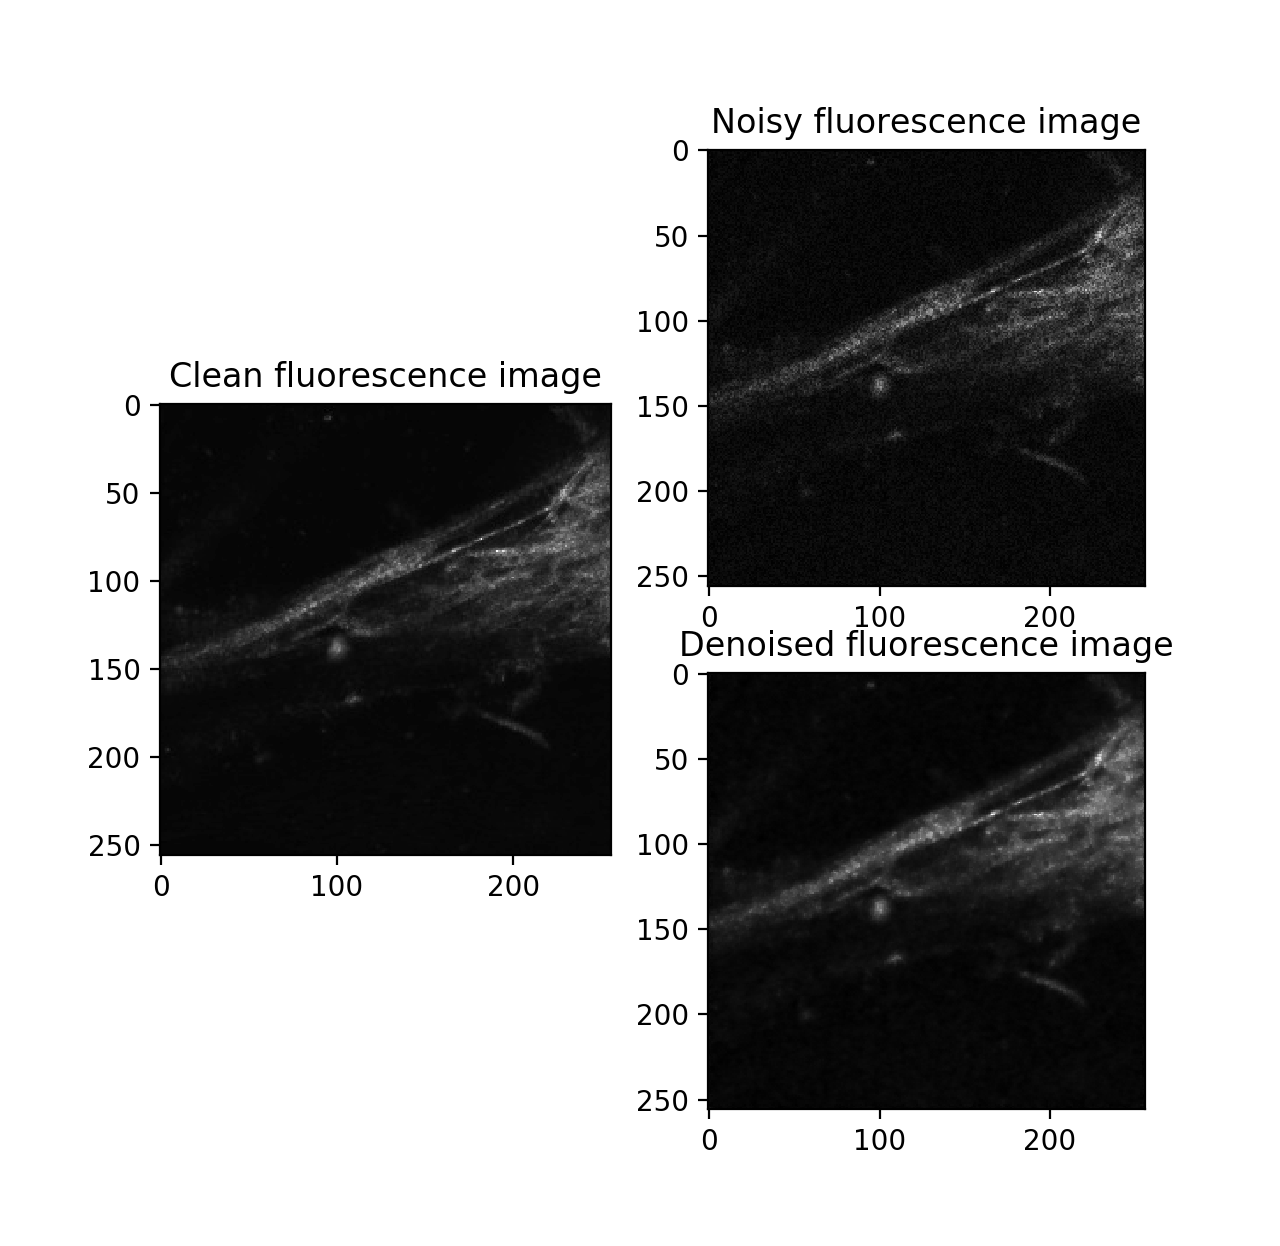

Text(0.5, 1.0, 'Denoised fluorescence image')

In [75]:
noisy_sample, clean_sample = val_dataset[3]
denoised_sample = model(noisy_sample.unsqueeze(0).float().to(device))

fig = plt.figure()
clean_plt = fig.add_subplot(121)
noisy_plt = fig.add_subplot(222)
denoised_plt = fig.add_subplot(224)
clean_plt.imshow(np.transpose(clean_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
clean_plt.set_title('Clean fluorescence image')
noisy_plt.imshow(np.transpose(noisy_sample.numpy(), (1,2,0))[:,:,0], cmap='gray')
noisy_plt.set_title('Noisy fluorescence image')
denoised_plt.imshow(np.transpose(denoised_sample.cpu().detach().numpy()[0], (1,2,0))[:,:,0], cmap='gray')
denoised_plt.set_title('Denoised fluorescence image')